# Laboratorio 4 - Familias de Malware
### Universidad del Valle de Guatemala
### Security Data Science

Andrés de la Roca - 20332

### I. Creacion del dataset / Extraccion de caractersiticas

In [52]:
import pefile
import os
import pandas as pd

#PE Header data
def extract_pe_header_features(file_path):
    pe = pefile.PE(file_path)

    machine_type = pe.FILE_HEADER.Machine
    number_of_sections = pe.FILE_HEADER.NumberOfSections
    time_date_stamp = pe.FILE_HEADER.TimeDateStamp
    characteristics = pe.FILE_HEADER.Characteristics

    return machine_type, number_of_sections, time_date_stamp, characteristics

# Section features
def extract_section_features(file_path):
    pe = pefile.PE(file_path)

    section_features = []
    for section in pe.sections:
        section_name = section.Name.decode('utf-8').rstrip('\x00')
        size_section = section.SizeOfRawData
        characteristics = section.Characteristics

        section_features.append((section_name, size_section, characteristics))

    return section_features

# Imported functions
def extract_imported_functions(file_path):
    pe = pefile.PE(file_path)

    imported_functions = []
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        dll = entry.dll.decode('utf-8')
        for function in entry.imports:
            if function.name is not None:
                imported_functions.append(function.name.decode('utf-8'))

    return imported_functions

# Exported functions
def extract_exported_functions(file_path):
    pe = pefile.PE(file_path)

    exported_functions = []
    if hasattr(pe, 'DIRECTORY_ENTRY_EXPORT'):
        for exp in pe.DIRECTORY_ENTRY_EXPORT.symbols:
            exported_functions.append(exp.name.decode('utf-8'))

    return exported_functions

# Extract strings
def extract_strings(file_path):
    pe = pefile.PE(file_path)
    ascii_strings = []
    unicode_strings = []

    for section in pe.sections:
        ascii_strings.extend(section.get_data().decode('ascii', errors='ignore').split('\x00'))
        unicode_strings.extend(section.get_data().decode('utf-16', errors='ignore').split('\x00'))

    return ascii_strings, unicode_strings


# Dataset creation function
def create_dataset(path):
    dataset = []

    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)

        try:

            if os.path.isfile(file_path):
                pe_header_features = extract_pe_header_features(file_path)
                section_features = extract_section_features(file_path)
                imported_functions = extract_imported_functions(file_path)
                exported_functions = extract_exported_functions(file_path)
                ascii_strings, unicode_strings = extract_strings(file_path)

                entry = {
                    'File_Path': file_path,
                    'PE_Header_Features': pe_header_features,
                    'Section_Features': section_features,
                    'Imported_Functions': imported_functions,
                    'Exported_Functions': exported_functions,
                    'ASCII_Strings': ascii_strings,
                    'Unicode_Strings': unicode_strings,
                }

                dataset.append(entry)
        except pefile.PEFormatError:
            print('Error reading file: {}'.format(file_path))
            continue

    
    data = pd.DataFrame(dataset)

    return data

In [53]:
path = "./MALWR"

mw_data = create_dataset(path)

print(mw_data)


Error reading file: ./MALWR/.DS_Store
                                           File_Path  \
0      ./MALWR/AAAz2E1B6940985A23E5639450F8391820655   
1       ./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44   
2           ./MALWR/65018CD542145A3792BA09985734C12A   
3           ./MALWR/8442AE37B91F279A9F06DE4C60B286A3   
4      ./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578   
5           ./MALWR/99A39866A657A10949FCB6D634BB30D5   
6        ./MALWR/K99_C3A9A7B026BFE0E55FF219FD6AA7D94   
7       ./MALWR/L11_1415EB8519D13328091CC5C76A624E3D   
8           ./MALWR/F8437E44748D2C3FCF84019766F4E6DC   
9      ./MALWR/POL55_A4F1ECC4D25B33395196B5D51A06790   
10      ./MALWR/DS22_A670D13D4D014169C4080328B8FEB86   
11     ./MALWR/PL98_BD8B082B7711BC980252F988BB0CA936   
12     ./MALWR/KLp90_6D5C8FC4B14559F73B6136D85B94198   
13      ./MALWR/GFT4_7DDD3D72EAD03C7518F5D47650C8572   
14          ./MALWR/1F2EB7B090018D975E6D9B40868C94CA   
15       ./MALWR/RTC_7F85D7F628CE62D1D8F7B39D8940472   
16    ./MA

In [54]:
mw_data.head()

,File_Path,PE_Header_Features,Section_Features,Imported_Functions,Exported_Functions,ASCII_Strings,Unicode_Strings
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"(332, 3, 1319015770, 8462)","[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...","[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍..."
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"(332, 3, 1242321160, 271)","[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄..."
2,./MALWR/65018CD542145A3792BA09985734C12A,"(332, 3, 1195429813, 271)","[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄..."
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"(332, 3, 1263576056, 271)","[(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄..."
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"(332, 3, 1319015949, 8462)","[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...","[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍..."


In [55]:
print(mw_data['Section_Features'])

0     [(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...
1     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
2     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
3     [(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...
4     [(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...
5     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
6     [(.text, 9728, 1610612768), (.rdata, 3072, 107...
7     [(UPX0, 0, 3758096512), (UPX1, 11776, 37580964...
8     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
9     [(.text, 9728, 1610612768), (.rdata, 3072, 107...
10    [(.text, 9728, 1610612768), (.rdata, 3072, 107...
11    [(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...
12    [(.text, 9728, 1610612768), (.rdata, 3072, 107...
13    [(.text, 9728, 1610612768), (.rdata, 3072, 107...
14    [(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...
15    [(UPX0, 0, 3758096512), (UPX1, 11776, 37580964...
16    [(UPX0, 0, 3758096512), (UPX1, 346112, 3758096...
17    [(UPX0, 0, 3758096512), (UPX1, 4096, 37580

### II. Preprocesamiento de datos

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# 1. Normalización para las características numéricas del PE Header
numeric_features = mw_data['PE_Header_Features']
numeric_features = pd.DataFrame(numeric_features.to_list(), columns=['Machine_Type', 'Number_of_Sections', 'TimeDateStamp', 'Characteristics'])
scaler = MinMaxScaler()
mw_data[['Machine_Type', 'Number_of_Sections', 'TimeDateStamp', 'Characteristics']] = scaler.fit_transform(numeric_features)

mw_data.drop(columns=['PE_Header_Features'], inplace=True)

mw_data.head()

,File_Path,Section_Features,Imported_Functions,Exported_Functions,ASCII_Strings,Unicode_Strings,Machine_Type,Number_of_Sections,TimeDateStamp,Characteristics
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...","[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.0,0.0,0.999999,1.0
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.379422,0.0
2,./MALWR/65018CD542145A3792BA09985734C12A,"[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.000000,0.0
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"[(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.551407,0.0
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...","[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.0,0.0,1.000000,1.0


In [57]:
# 2. Categorizacion para las características de las secciones
section_features = mw_data['Section_Features']
section_features = section_features.apply(lambda x: [section[0] for section in x])
section_features = section_features.apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer()
section_features = vectorizer.fit_transform(section_features)
section_features = pd.DataFrame(section_features.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, section_features], axis=1)
mw_data.drop(columns=['Section_Features'], inplace=True)

mw_data.head()
# Se enfoco en tomar los nombres de las secciones

,File_Path,Imported_Functions,Exported_Functions,ASCII_Strings,Unicode_Strings,Machine_Type,Number_of_Sections,TimeDateStamp,Characteristics,data,rdata,rsrc,text,upx0,upx1,upx2
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...","[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.0,0.0,0.999999,1.0,0,0,0,0,1,1,1
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.379422,0.0,0,0,1,0,1,1,0
2,./MALWR/65018CD542145A3792BA09985734C12A,"[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.000000,0.0,0,0,1,0,1,1,0
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.551407,0.0,0,0,1,0,1,1,0
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...","[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.0,0.0,1.000000,1.0,0,0,0,0,1,1,1


In [58]:
# 3. Funciones importadas y exportadas
imported_functions = mw_data['Imported_Functions']
imported_functions = imported_functions.apply(lambda x: ' '.join([str(i) for i in x]))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(imported_functions)
imported_functions = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, imported_functions], axis=1)
mw_data.drop(columns=['Imported_Functions'], inplace=True)

exported_functions = mw_data['Exported_Functions']
exported_functions = exported_functions.apply(lambda x: ' '.join([str(i) for i in x]))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(exported_functions)
exported_functions = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, exported_functions], axis=1)
mw_data.drop(columns=['Exported_Functions'], inplace=True)

mw_data.head()


,File_Path,ASCII_Strings,Unicode_Strings,Machine_Type,Number_of_Sections,TimeDateStamp,Characteristics,data,rdata,rsrc,...,wcsrchr,wcstombs,wsagetlasterror,wsasetlasterror,wsastartup,rundllinstall,rundlluninstall,serviceinstall,servicemain,unserviceinstall
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.0,0.0,0.999999,1.0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.379422,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,./MALWR/65018CD542145A3792BA09985734C12A,"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.000000,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.0,0.0,0.551407,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.0,0.0,1.000000,1.0,0,0,0,...,0,0,1,0,0,1,1,1,1,1


In [59]:
# Borrando las columnas que no se usan
mw_data.drop(columns=['File_Path', 'Machine_Type', 'Number_of_Sections'], inplace=True)


In [60]:
mw_data.head()

,ASCII_Strings,Unicode_Strings,TimeDateStamp,Characteristics,data,rdata,rsrc,text,upx0,upx1,...,wcsrchr,wcstombs,wsagetlasterror,wsasetlasterror,wsastartup,rundllinstall,rundlluninstall,serviceinstall,servicemain,unserviceinstall
0,"[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",0.999999,1.0,0,0,0,0,1,1,...,0,0,1,0,0,1,1,1,1,1
1,"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.379422,0.0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.000000,0.0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,"[, D$T$\t3t! 3-%, \t\rt%, ? t""@ ...","[, ￿䒋ࠤ咋Ф좋茉ǡ쨳ⅴ턋㏩＃럭ጭЃＥϿऀ턍ǁʹ臉ﬥ쌁ି셴즶༢Єὀ뀆툁㼌혡덴̓㺄...",0.551407,0.0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,"[, U, , SVWh, \n4, a3;6E3(PMYY$POgWSOE...","[, ￿￿譕臬賬匀坖hＴ愈诰㏸㯛࿻￯쾄㘁䖍㏐倨ᇨ퐁ﻂ큍奙値俿빧南俴讧ࡅ䶍觤ᡆ鬶￭䚍...",1.000000,1.0,0,0,0,0,1,1,...,0,0,1,0,0,1,1,1,1,1


In [61]:
# 4. Procesamiento de las cadenas de texto
ascii_strings = mw_data['ASCII_Strings']

ascii_strings = ascii_strings.apply(lambda x: ' '.join([str(i) for i in x]))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ascii_strings)
ascii_strings = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, ascii_strings], axis=1)
mw_data.drop(columns=['ASCII_Strings'], inplace=True)
mw_data.drop(columns=['Unicode_Strings'], inplace=True)

# Filtrando características con baja varianza
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
mw_data = pd.DataFrame(selector.fit_transform(mw_data))


print(mw_data.head())

   0     1     2     3     4     5     6     7     8     9     ...  4358  \
0   1.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0  ...   8.0   
1   0.0   0.0   0.0   1.0   0.0   1.0   1.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   1.0   0.0   1.0   1.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   1.0   0.0   1.0   1.0   0.0   0.0   0.0  ...   0.0   
4   1.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0  ...   9.0   

   4359  4360  4361  4362  4363  4364  4365  4366  4367  
0   0.0   1.0   7.0   7.0   7.0   1.0   1.0   1.0   2.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   1.0   8.0   6.0   3.0   1.0   1.0   1.0   0.0  

[5 rows x 4368 columns]


### III. Implementacion del modelo

In [62]:
# Guardar el dataset
mw_data.to_csv('malware_dataset.csv', index=False)

# Cargar el dataset
mw_data = pd.read_csv('malware_dataset.csv')

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [64]:
print(mw_data.head())
X = mw_data.values
print(X)

     0    1    2    3    4    5    6    7    8    9  ...  4358  4359  4360  \
0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   8.0   0.0   1.0   
1  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   9.0   0.0   1.0   

   4361  4362  4363  4364  4365  4366  4367  
0   7.0   7.0   7.0   1.0   1.0   1.0   2.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   8.0   6.0   3.0   1.0   1.0   1.0   0.0  

[5 rows x 4368 columns]
[[1. 0. 0. ... 1. 1. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]


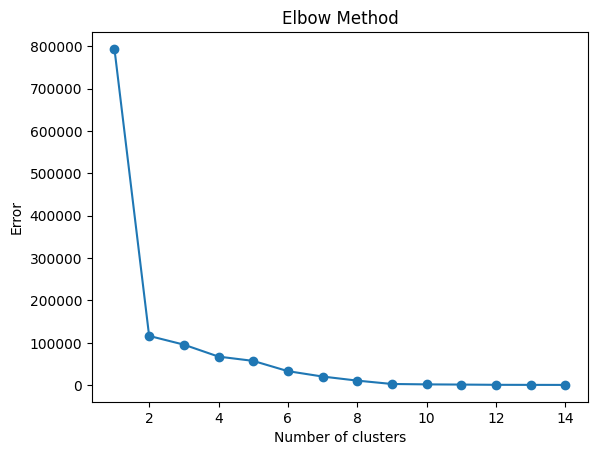

In [65]:
# KMeans - Elbow Method

kmeans_errors = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    kmeans_errors.append(kmeans.inertia_)
plt.plot(range(1, 15), kmeans_errors, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Error')
plt.show()


Utilizando el algoritmo de KMeans, se puede determinar de manera empirica observando la figura anterior que el numero optimos de clusters se puede encontrar entre 2 y 4, aunque inclusive se podria considerar mas numero de clusters siguiendo la regla tipica, en donde se considera que el numero de clusters debe de ser donde la grafica empieza a aplanarse. Mas adelante con el uso de la metrica de Silhouette podria ayudarnos a determinar de manera mas precisa y con menos subjetividad el numero de clusters optimos.

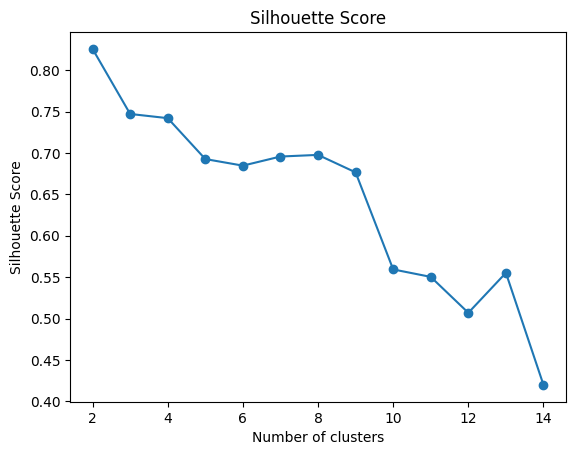

In [66]:
# kmeans - Silhouette score 
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    silhouette_scores.append(silhouette_score(X, labels))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


Se puede observar que el numero optimo de clusters es 2, aunque incluso se podrian considerar 3 y 4 clusters ya que la grafica muestra como el silhouette score es muy cercano entre estos puntos. El apoyarnos por medio de esta metrica nos ayuda a determinar de manera mucho menos ambigua el numero de clusters optimos, ya que nos da un valor numerico en el que podemos apoyarnos para realizar la decision.

Por lo que del lado del algoritmo KMeans, se podria decir que hay entre 2 y 4 familias de malware identificables en el conjunto de datos propuesto, es importante que antes de llegar a una conclusion definitiva se exploren las otras opciones, por lo que a continuacion se procedera a realizar el mismo analisis pero con el algoritmo de Agglomerative Clustering.

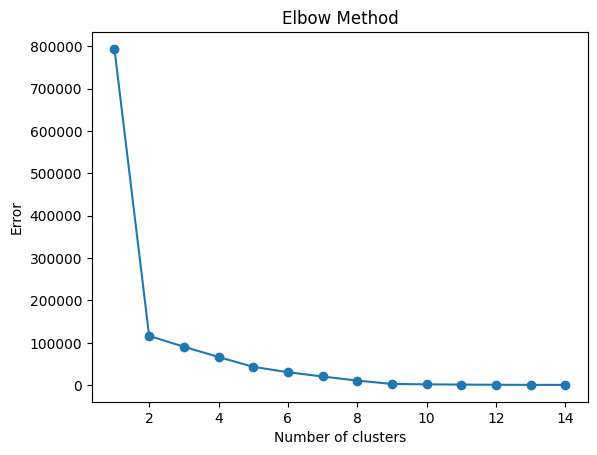

In [68]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min

wcss = []
for i in range(1, 15):
    agg = AgglomerativeClustering(n_clusters=i, linkage='ward')
    agg.fit(X)
    centroids = []
    for cluster in range(i):
        centroids.append(X[agg.labels_ == cluster].mean(axis=0))
    distances = pairwise_distances_argmin_min(X, centroids)[1]
    wcss.append(np.sum(distances ** 2))

plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Error')

plt.show()

En la grafica se puede observar que el metodo del codo nos da un resultado bastante similar al de KMeans, por lo que de igual manera nos muestra que 2, 3 y 4 podrian ser opciones validas de cantidad de clusters/familias de malware identificados. La metrica del Silhouette score nos ayudara a poder determinar de manera mas clara el numero de clusters optimos para este caso.

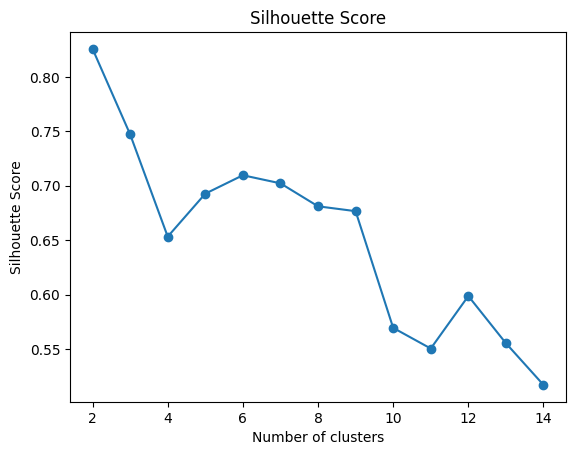

In [69]:
# Agglomerative Clustering - Silhouette score
silhouette_scores = []
for k in range(2, 15):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(X)
    labels = agg.labels_
    silhouette_scores.append(silhouette_score(X, labels))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


De acuerdo a las metricas obtenidas a traves de este analisis por Silhouette score, se podria decir que el numero optimo de clusters es 2 o 3, ya que segun los valores obtenidos, el utilizar 4 clusters no alcanza un valor tan alto, es decir que en promedio los archivos no estan tan cerca del centro de sus respectivos clusters.

Por lo que se puede decir a traves de estos resultados que el numero de familias de malware identificables en el conjunto de datos propuesto es de 2 o 3, ya que el resultados de ambos algoritmos nos muestra la tendencia de que esta cantidad de clusters es la optima. Se podria decir que el Silhouette score fue la metrica diferenciadora al analizar ambos resultados ya que nos muestra que tan cerca estan los puntos de sus respectivos clusters, y por lo tanto no lo deja a la subjetividad de la persona que esta realizando el analisis, a diferencia del metodo del codo que si puede ser un poco mas subjetivo, en especial con los datos obtenidos donde no esta claro donde es el "codo" de la grafica.

### Analisis de similitud

#### Strings

Umbral = 0.6

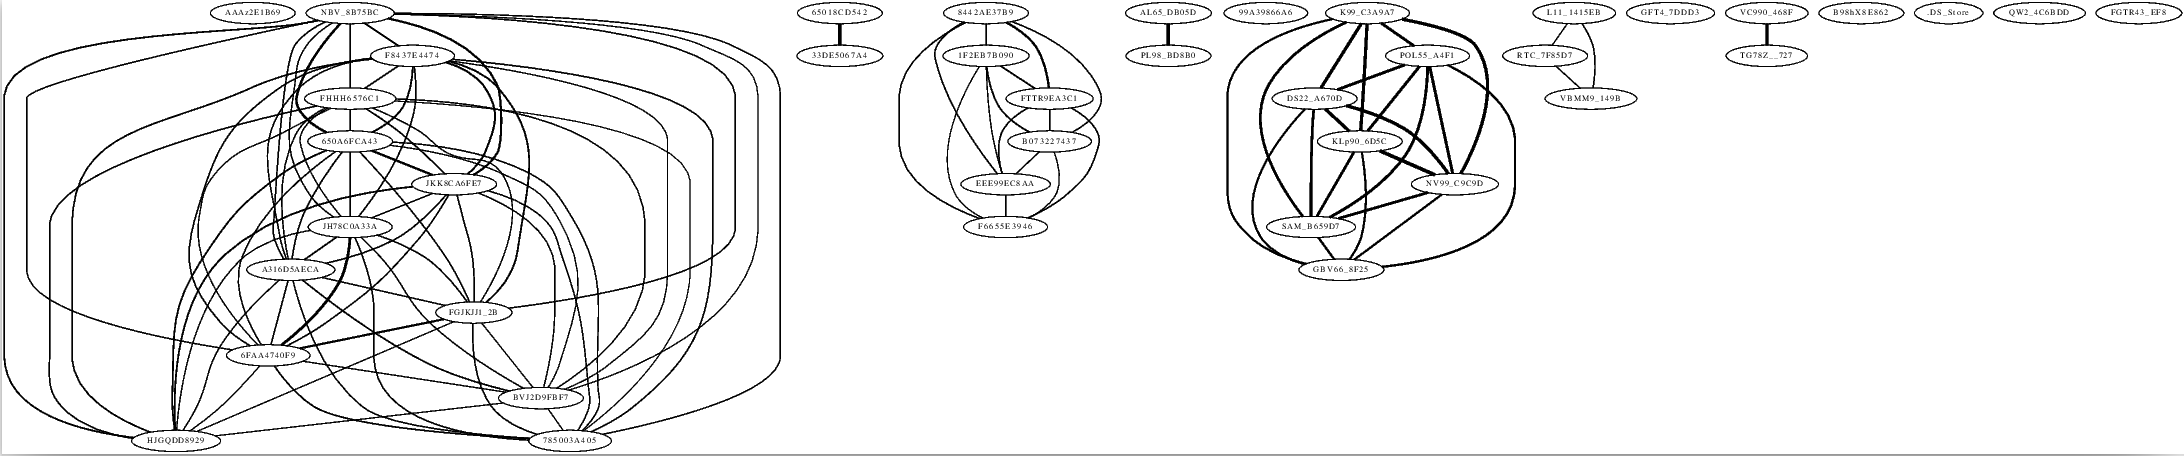

Umbral = 0.7

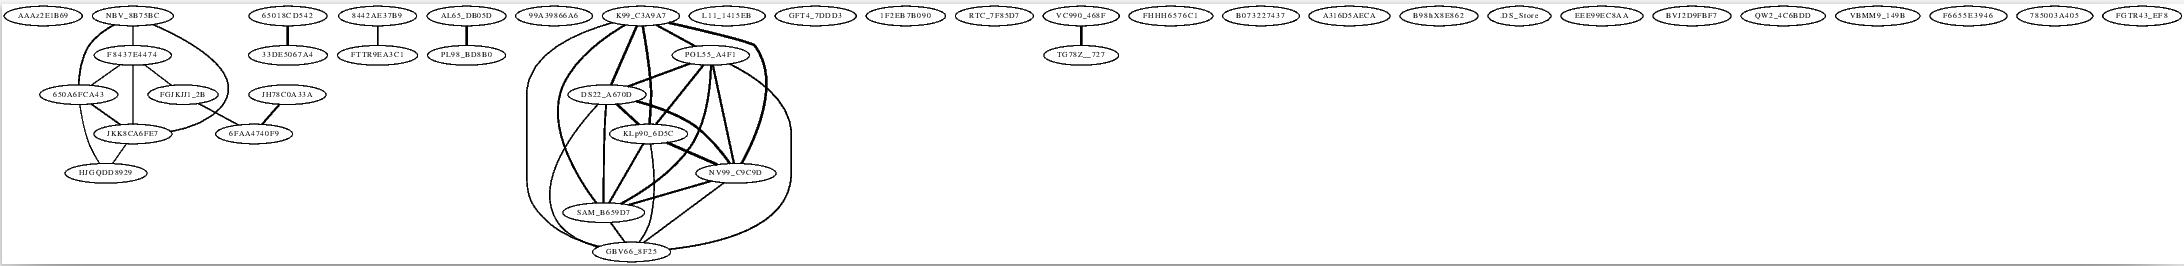

Umbral = 0.8

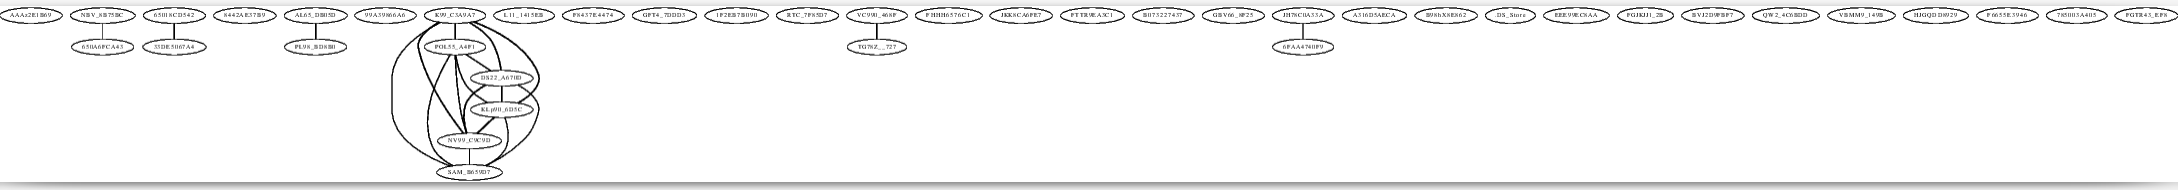

#### Nombres de las secciones

Umbral = 0.6

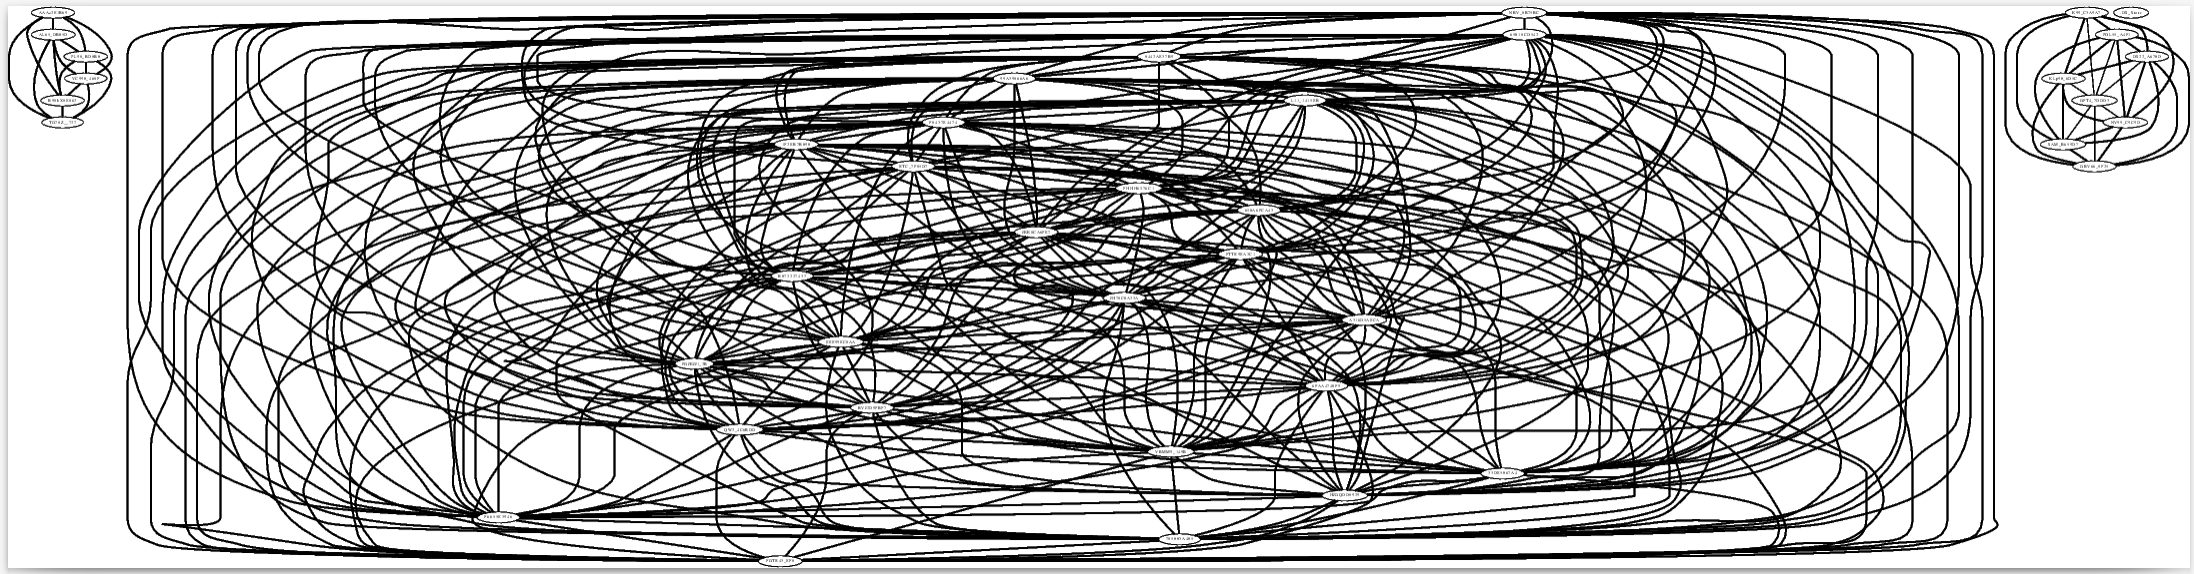

Umbral = 0.7

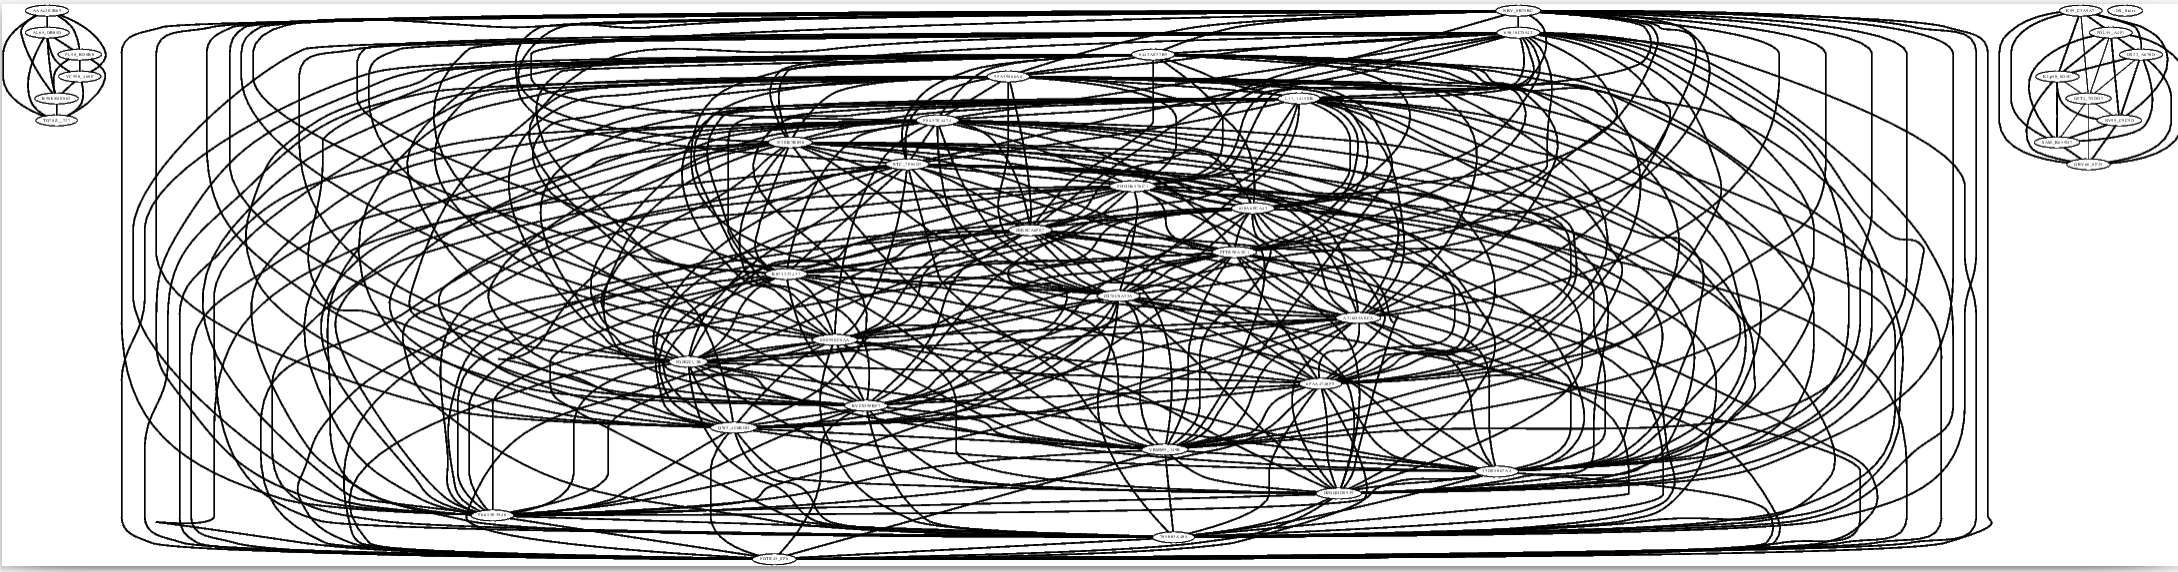

Umbral = 0.8

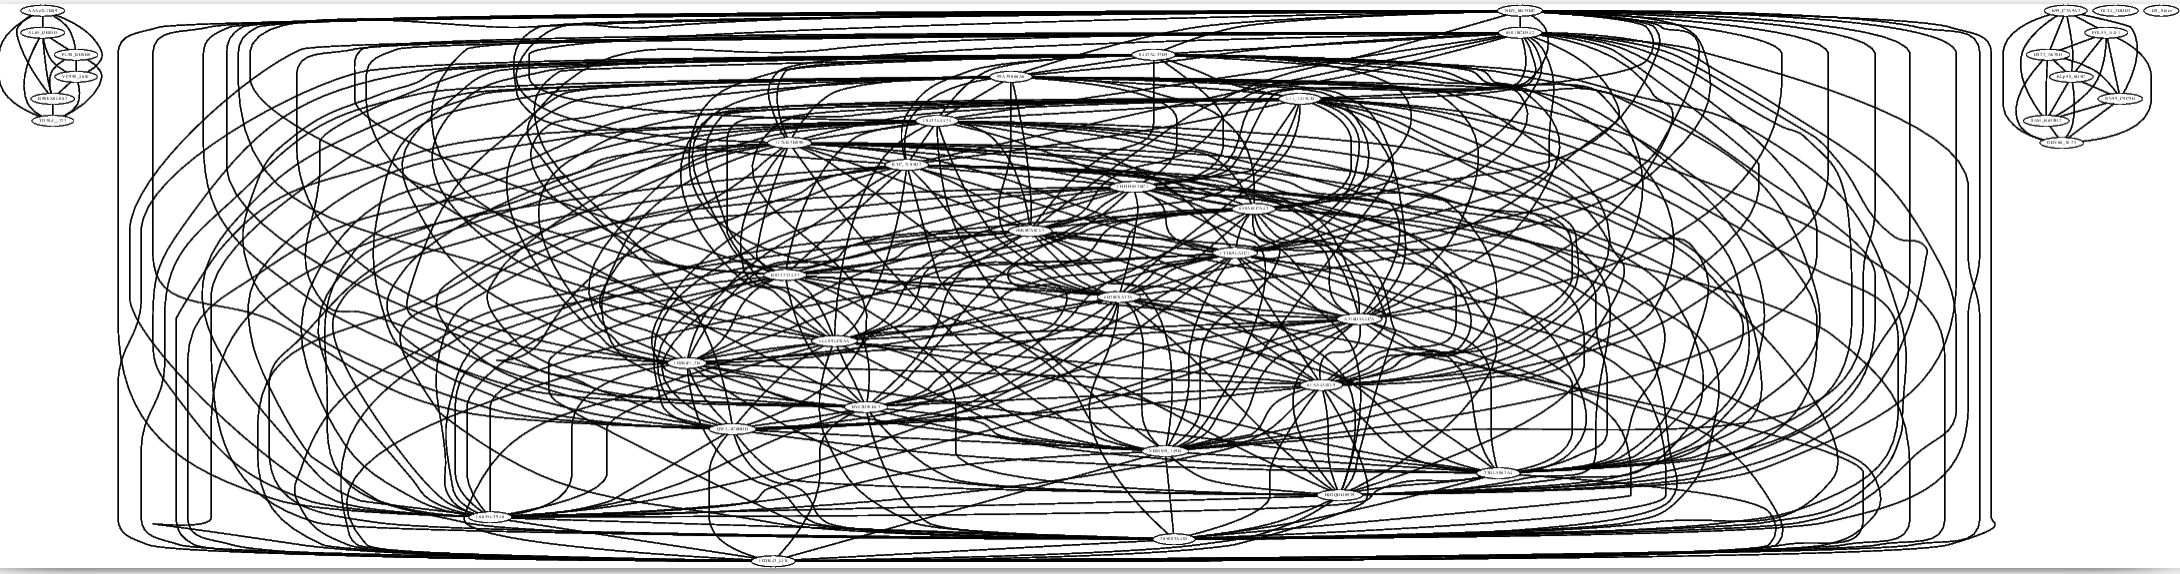

### Conclusiones

1. Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?  
R/.
2. Para ambos algoritmos, ¿En que medida coincide el coeficiente de Silhouette con el método del codo?  
R/.
3. Según los resultados obtenidos de ambos algoritmos ¿Cuántas familias cree que existen entre los ejemplares de malware proporcionados?  
R/.
4. ¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los algoritmos de partición, para ambas características (strings, llamadas a las funciones)?  
R/.
